## BP - F Pytorch

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import sys
import os

### Data Reading & Preprocessing

In [4]:
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)
csv_path = os.path.join(project_root, "archive", "preprocessed_files", "processed.csv")
df = pd.read_csv(csv_path)

In [5]:
X = df.drop(columns=["log_price"], axis=1)
y = df["log_price"]

X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)

y = y.values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Model Training & Testing

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, dropout_rate=0.5):
        super().__init__()
        # Definimos la capa Dropout
        self.dropout = nn.Dropout(p=dropout_rate) # Usando 0.5 como valor estándar
        
        self.flatten = nn.Flatten()
        
        # Insertamos la capa Dropout en el stack
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.Tanh(),
            # 1. Añadimos Dropout después de la primera ReLU
            self.dropout, 
            nn.Linear(64, 32),
            nn.Tanh(),
            self.dropout, 
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [8]:
model = NeuralNetwork(n_features=X_train.shape[1])

In [9]:
# 1. Crear el scaler
scaler = StandardScaler()

# 2. Ajustar el scaler solo con el set de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.fit_transform(y_test.reshape(-1, 1))

# 3. (Opcional pero recomendado) Escalar también el test, pero sin fit
X_test_scaled = scaler.transform(X_test)

# 4. Convertir a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

#### Train

In [10]:
epochs = 400

train_losses = []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Entrenamiento
for epoch in range(epochs):
    # Forward
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    optimizer.zero_grad()  # reiniciar gradientes
    loss.backward()        # calcular gradientes
    optimizer.step()        # actualizar pesos

    train_losses.append(loss.item())
    

    # Mostrar progreso
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


Epoch [20/400], Loss: 0.512729
Epoch [40/400], Loss: 0.399138
Epoch [60/400], Loss: 0.379891
Epoch [80/400], Loss: 0.364886
Epoch [100/400], Loss: 0.355161
Epoch [120/400], Loss: 0.349030
Epoch [140/400], Loss: 0.341684
Epoch [160/400], Loss: 0.337518
Epoch [180/400], Loss: 0.348547
Epoch [200/400], Loss: 0.329854
Epoch [220/400], Loss: 0.335730
Epoch [240/400], Loss: 0.336665
Epoch [260/400], Loss: 0.330382
Epoch [280/400], Loss: 0.336625
Epoch [300/400], Loss: 0.324031
Epoch [320/400], Loss: 0.324499
Epoch [340/400], Loss: 0.327791
Epoch [360/400], Loss: 0.327896
Epoch [380/400], Loss: 0.326563
Epoch [400/400], Loss: 0.324610


In [11]:
# Predicciones del modelo
model.eval()  # modo evaluación (sin dropout, etc)
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()

# Convertir a numpy si hace falta
y_true = y_train_tensor.numpy()

# Calcular R²
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_true, y_pred_train)
mse = mean_squared_error(y_true, y_pred_train)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")


R²: 0.7163
MSE: 0.2837


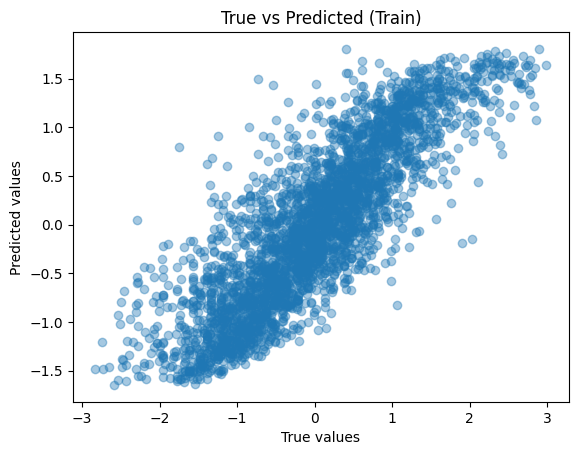

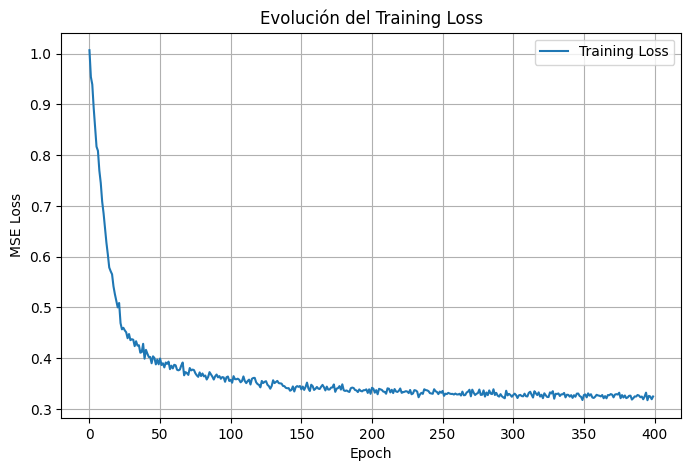

In [12]:
plt.scatter(y_true, y_pred_train, alpha=0.4)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs Predicted (Train)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Evolución del Training Loss")
plt.legend()
plt.grid(True)
plt.show()


#### Test

In [13]:
model.eval()  # Modo evaluación: desactiva dropout, batchnorm, etc.

with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)

print(f"Test Loss (MSE): {test_loss.item():.6f}")


Test Loss (MSE): 0.292436


In [14]:
from sklearn.metrics import r2_score

# Convertimos a numpy
y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred_test.numpy()

r2 = r2_score(y_test_np, y_pred_np)
print(f"R² en test: {r2:.4f}")


R² en test: 0.7076
